<a href="https://colab.research.google.com/github/toheedakhtar/pytorch-deeplearning/blob/main/notebooks/04_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Pytorch Custom Datasets

How do you get your own data in PyTorch.  
one of the ways is custom datset.

## Domain libraries
depending on what you're working on , vision, text, audio, recommendation, you'll want to look into each of the PyTorch exisitng data loading functions and customizable data loading functions.

## 0. Importing pytorch and setting up device agnostic code

In [73]:
import torch
from torch import nn

torch.__version__

'2.4.1+cu121'

In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data

our dataset is a subset of Food101 dataset.  
Food101 has 101 different classes of food.  
our dataset starts with 3 classes of food and 10% images of Food101 dataset  
(75train - 25test)  

Why do this?  
when starting out ML Projects, its important to try things on a small scale and then increaes the scale when necessary.  

The whole point is to speed up how fast you can experiment.

In [75]:
import requests
import zipfile
from pathlib import Path

# setup path to a datafolder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if image folder dosen't exist download
if image_path.is_dir():
  print(f"{image_path} dir already exists..Skipping to download.")
else:
  print(f"{image_path} dir dosen't exists.. creting one.")
  image_path.mkdir(parents=True, exist_ok=True)

# download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Download dataset...")
  f.write(request.content)

# unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("unzipiing data...")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi dir already exists..Skipping to download.
Download dataset...
unzipiing data...


## 2. Becoming one with the data (data preperation and data exploration)


In [76]:
import os
def walk_through_dir_path(dir_path):
  """Walks through dir_path returning its content"""

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")


In [77]:
walk_through_dir_path(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [78]:
# setup train and test path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir , test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and Image

1. Get all of image path
1. Pick a random image path using python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with image, open the image with Python PIL library.
5. We'll then show the image and show metadata

In [79]:
import random
from PIL import Image

In [80]:
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

[PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2144308.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1627703.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sush

Random image path : data/pizza_steak_sushi/test/sushi/858157.jpg
Image class : sushi
image height: 288
Image width : 512


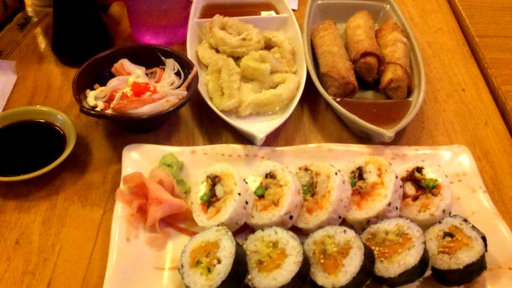

In [81]:
# 2. pick random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class, name of parent dir where image is stored
image_class = random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. print metadata
print(f"Random image path : {random_image_path}\nImage class : {image_class}")
print(f"image height: {img.height}\nImage width : {img.width}")
img

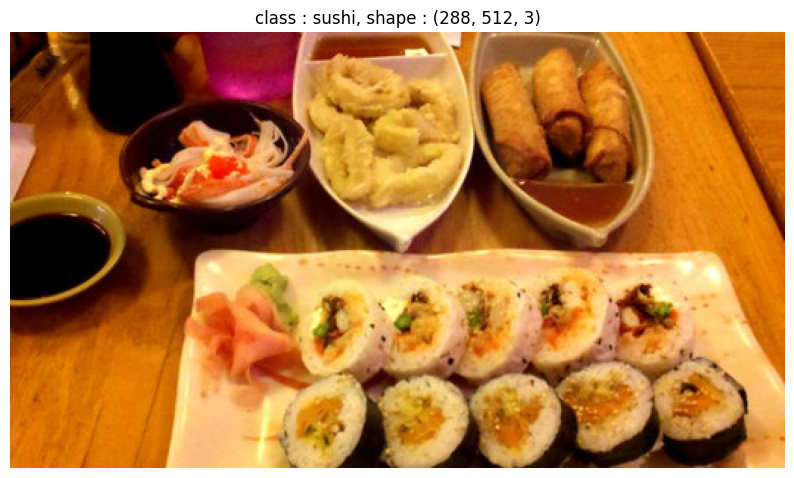

In [82]:
# visuailizg with matplotib
import numpy as np
import matplotlib.pyplot as plt

# turn image into array
image_as_array = np.asarray(img)

# plot the img with plt
plt.figure(figsize=(10,7))
plt.imshow(image_as_array)
plt.title(f"class : {image_class}, shape : {image_as_array.shape}")
plt.axis(False);

## 3. Transforming data

Before we can use our image data with PyTorch:  
1. Turn your target data into tensores (our case -> numerical representations of our images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, Dataset and Dataloader


In [83]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transformimg data with `torchvision.transform`

In [84]:
# write a transform for image
data_transform = transforms.Compose([
    # Resize our image to 64x64
    transforms.Resize(size=(64,64)),
    # flip the image randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tenosr
    transforms.ToTensor()
])

In [85]:
data_transform(img).shape

torch.Size([3, 64, 64])

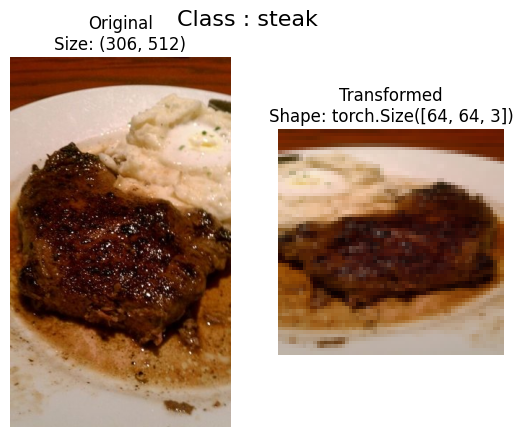

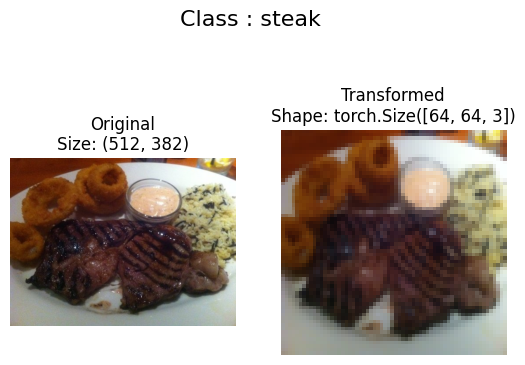

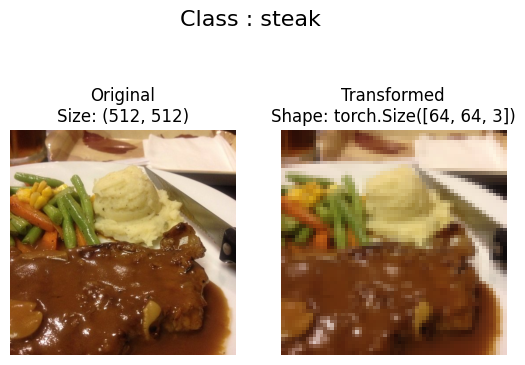

In [86]:
def plot_transformed_images(image_paths : list, transform, n=3, seed=None):
  """
  Selects random images from a path of image and transforms it
  then plots original vs transformed version.
  """

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # transform and plot target image
      transformed_image = transform(f).permute(1,2,0)    # change shape for matplotlib (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class : {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list, transform=data_transform, seed=None, n=3)

## 4. Option 1 : Loading image data using `ImageLoader`

We can load image classification data usign `torchvision.datasets.ImageFolder`

In [87]:
# using ImageFolder
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform, target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [88]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [89]:
# get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [90]:
# checking lengths
len(train_data), len(test_data)

(225, 75)

In [91]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [92]:
# index on train_data Dataset to get single image and label
img, label = train_data[0][0] , train_data[0][1]
print(f"Image tesnor: {img}")
print(f"Image shape : {img.shape}")
print(f"Image dtype: {img.dtype}")
print(f"Image label: {label}")
print(f"label dtype: {type(label)}")


Image tesnor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

In [93]:
class_names[label]

'pizza'

Text(0.5, 1.0, 'pizza')

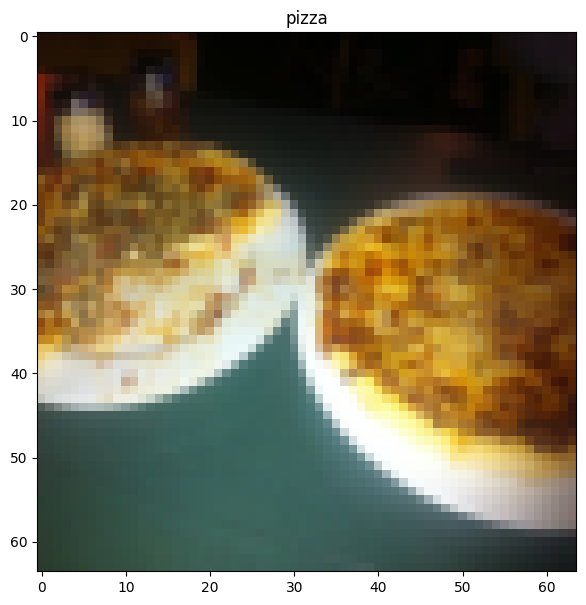

In [94]:
# rearragne the order dimensions
img_permute = img.permute(1,2,0)

# plot image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.title(class_names[label])


## 4.1 Turn loaded images into `DataLoader's`

A `Dataloder` is going to help us turn our `dataset` into iterables and we can customize  
`batch_size` so our model can see `batch_size` at times

In [95]:
# turn train and test datasets into dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7836fb086a40>,
 <torch.utils.data.dataloader.DataLoader at 0x7836fb086b00>)

In [96]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [97]:
img, label = next(iter(train_dataloader))

print(img.shape)
print(label.shape)


torch.Size([1, 3, 64, 64])
torch.Size([1])


## 5. Option 2 : Loading Image Data with Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros :
1. Can create a `Dataset` out of almost anything
2. NOt limited to Pytorch pre-built `Dataset` functions

Cons :
1. Even though you could create `Dataset` out of almost anything, it doesn't mean it will work
2. Using a custom `Dataset` often results in writing more code which can result in performance issues or erros



In [98]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [99]:
# instance of torchvision.datasets.ImageFolder
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

we want a function to:
1. get class names using `os.scandir()` to traverse a target
2. Raise an error if class names are'nt found (if it happens, somethin's wrong with directory structure)
3. Turn class names into list and dict and return them

In [100]:
target_directory = train_dir
print(target_directory)

# get class names from directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [101]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target dictionary"""
  # get class names by scanning the target directory.
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class name could'nt be found
  if not classes:
    raise FileNotFoundError(f"Could'nt find any classes in {directory}")

  # 3. create dictionary of index labels
  class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [102]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset , we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory
3. Create several attributes
  * paths 0 paths of images
  * transform - transform we'd like to use
  * classes - a list of target classes
  * class_to_idx - a dict of the target classes mapped ot integer labels
4. Create a func `load_images` , the func will open image
5. overwrite the `__len()__` method to return the length of our dataset
6. overwrite the `__getitem()__` method to return a given sample when passed an index


In [103]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [104]:
# create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [105]:
# test out ImageFolderCustom

train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)


In [106]:
train_data_custom , test_data_custom

(<__main__.ImageFolderCustom at 0x7836fb59f0a0>,
 <__main__.ImageFolderCustom at 0x7836fb086380>)

In [107]:
len(train_data), len(train_data_custom)

(225, 225)

In [108]:
len(test_data), len(test_data_custom)


(75, 75)

In [109]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [110]:
# check for equality b/w ImageFolder and ImageFolderCustom
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other params such as class names and how many images to visualize
2. cap no of images to 10
3. set random seed
4. get list of random sample indexes from the target dataset.
5. setup matplotlib plot
6. loop through the random sample index and plot them
7. dimension of our images line up with matplotlib (HWC)

In [111]:
# 1. func to take in dataset
def display_random_images(dataset : torch.utils.data.Dataset,
                          classes : List[str]= None,
                          n:int = 10,
                          display_shape : bool = True,
                          seed : int = None):

  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"for display n should'nt be greater than 10.")

  # 3. seed
  if seed:
    random.seed(seed)

  # 4. get list of random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. setup plot
  plt.figure(figsize=(16, 8))

  # 6. loop through random sample index and plot
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0)

    # plot adjusted sample
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class:{classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape :{targ_image_adjust.shape}"
    plt.title(title)

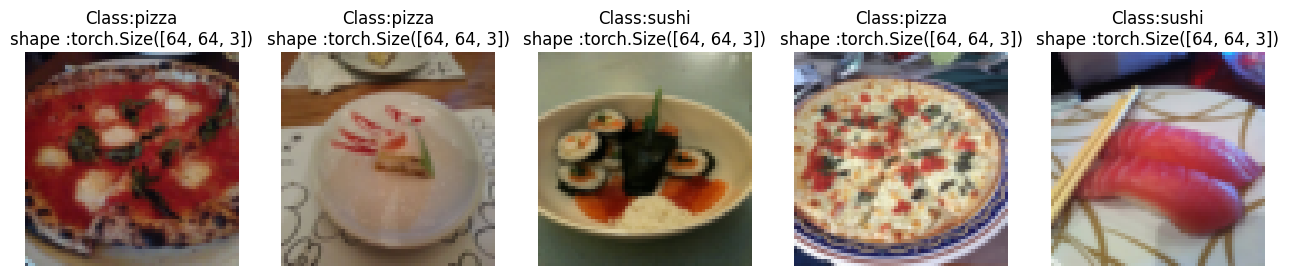

In [112]:
display_random_images(train_data, n=5, classes=class_names, seed=None)

for display n should'nt be greater than 10.


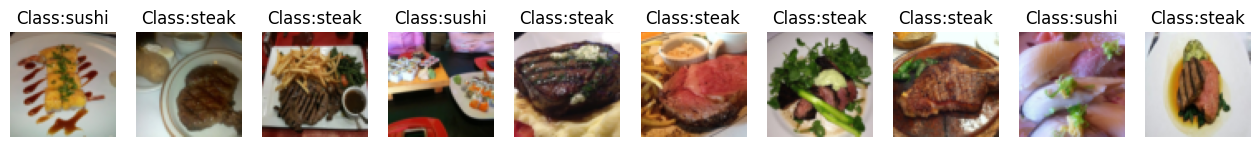

In [113]:
display_random_images(train_data_custom, n=20, classes=class_names, seed=42)

### 5.4 Turn custom loaded images into `DataLoaders`

In [114]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True
                                     )

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=False
                                     )

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x78371442fa60>,
 <torch.utils.data.dataloader.DataLoader at 0x7837146775b0>)

In [115]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms ( data augmentation )

Data augmentation is the process of artifically adding diverstity to your training data.  
In this case it means applying varioys image transformations to data.

Helps in generalizing unseen data.

In [116]:
from torchvision import transforms

train_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=5),
                                      transforms.ToTensor()
                                      ])

test_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=5),
                                      transforms.ToTensor()
                                      ])

In [117]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2144308.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1627703.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg')]

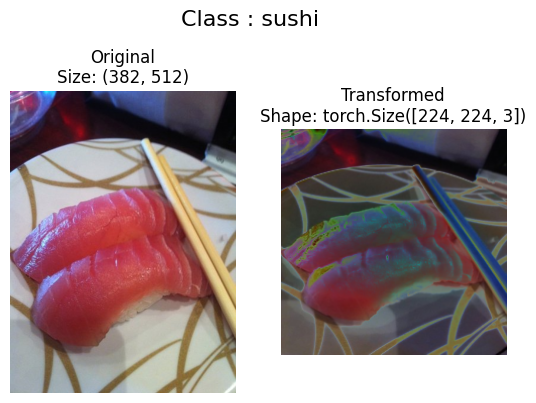

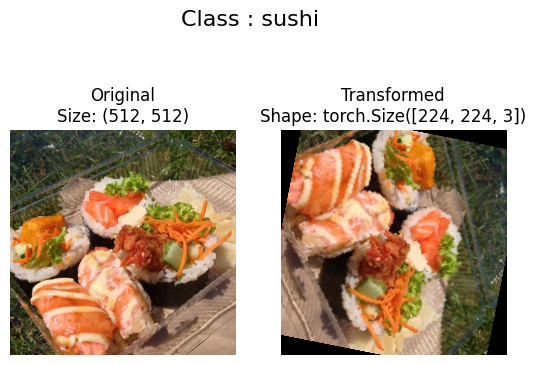

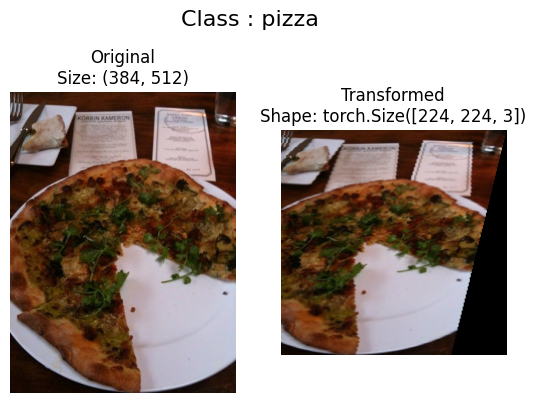

In [118]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3, seed=None
)

## 7 Model 0 : TinyVGG without data augmentations.

### 7.1 Creating and loading data for Model 0

In [138]:
# create simple transfom
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
])

In [139]:
# load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                          transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                          transform=simple_transform)

# 2. Turn dataset into DataLoader
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

In [165]:
train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x783714658e20>,
 <torch.utils.data.dataloader.DataLoader at 0x783714658580>)

### 7.2 Create TinyVGG Model Class

In [150]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: https://horace.io/brrr_intro.html

In [151]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)
                  ).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single Image

In [148]:
# get single image batch
image_batch , label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [152]:
# forward pass
model_0(image_batch)

tensor([[ 2.0885e-02, -4.0333e-03,  1.1070e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 2.1457e-02, -1.8471e-03,  7.7899e-03],
        [ 2.0329e-02, -2.7594e-03,  9.1032e-03],
        [ 1.9547e-02, -1.1828e-03,  1.1937e-02],
        [ 1.7633e-02, -1.7808e-03,  7.5870e-03],
        [ 1.9826e-02, -3.8645e-03,  9.8465e-03],
        [ 2.0641e-02, -3.2445e-03,  7.5635e-03],
        [ 2.2108e-02, -2.7411e-04,  6.3588e-03],
        [ 1.8574e-02, -4.1228e-03,  1.0566e-02],
        [ 2.1909e-02, -4.9545e-03,  9.4220e-03],
        [ 2.1925e-02, -7.6101e-04,  1.0494e-02],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 2.2926e-02, -1.4961e-03,  1.0282e-02],
        [ 1.9832e-02, -1.3674e-03,  1.1364e-02],
        [ 2.1985e-02,  4.3876e-04,  1.1393e-02],
        [ 1.9522e-02, -1.8429e-03,  8.8705e-03],
        [ 1.9252e-02,  4.0491e-04,  7.2784e-03],
        [ 2.3116e-02, -5.6550e-03,  1.1531e-02],
        [ 1.8531e-02, -9.9964e-05,  8.0369e-03],
        [ 2.0047e-02

In [145]:
13*13

169

### 7.4 Use `torchinfo` to get an idea of shapes going through our model

In [154]:
! pip install torchinfo
import torchinfo

from torchinfo import summary

In [156]:
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops function

* `train_step()` - takes in a model and dataloader and trains the model on dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on dataloader

In [188]:
# create train step

def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()

  # setup train loss and accuracy per batch
  train_loss, train_acc = 0, 0

  # loop through data loader
  for batch, (X,y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)

    # forward pass
    y_pred = model(X)

    # calc loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # optimizer zero
    optimizer.zero_grad()

    #loss backward
    loss.backward()

    # step
    optimizer.step()

    # calc accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # get avg loss and acc per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [189]:
# create test step

def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               device=device):

  # setup train loss and accuracy per batch
  test_loss, test_acc = 0, 0

  model.eval()

  # loop through data loader
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X,y = X.to(device), y.to(device)

      # forward pass
      y_pred = model(X)

      # calc loss
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()

      # calc accuracy
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      test_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # get avg loss and acc per batch
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc

### 7.6 creating `train` function combing `train_step()` and `test_step()`

In [202]:
from tqdm.auto import tqdm
def train(model:torch.nn.Module,
          train_datalaoder : torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn : torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int =5,
          device=device):

  results= {
      "train_loss" : [],
      "train_acc" : [],
      "test_loss" : [],
      "test_acc" : []
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)

    print(f"Epoch {epoch} | Train loss : {train_loss:.4f} | Test loss : {test_loss:.4f} | Train acc : {train_acc:.4f}, test_acc : {test_acc:.4f} ")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results




### 7.7 Train and evaluate model 0

In [203]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

from timeit import default_timer as timer

start_time = timer()

model_0_results = train(model=model_0, train_datalaoder=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple, loss_fn=loss_fn,
                        optimizer=optimizer, epochs=NUM_EPOCHS,
                        )

end_time = timer()
print(f"total train time : {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 | Train loss : 1.1025 | Test loss : 1.0959 | Train acc : 0.3556, test_acc : 0.3229 
Epoch 1 | Train loss : 1.0336 | Test loss : 1.0015 | Train acc : 0.4978, test_acc : 0.3930 
Epoch 2 | Train loss : 0.9707 | Test loss : 0.9925 | Train acc : 0.5422, test_acc : 0.4848 
Epoch 3 | Train loss : 0.9317 | Test loss : 0.9904 | Train acc : 0.5600, test_acc : 0.3930 
Epoch 4 | Train loss : 0.9038 | Test loss : 0.9989 | Train acc : 0.5956, test_acc : 0.4754 
total train time : 18.350 seconds


### 7.8 Plot loss curve of Model 0

it is a way of tracking model's progress over time

In [204]:
model_0_results

{'train_loss': [1.102525122695499,
  1.0335819589595,
  0.970675091660685,
  0.9317123914489316,
  0.9038434543667568],
 'train_acc': [0.35555555555555557,
  0.49777777777777776,
  0.5422222222222223,
  0.56,
  0.5955555555555555],
 'test_loss': [1.095891276995341,
  1.0014595588048298,
  0.9924788872400919,
  0.9904260436693827,
  0.9988920291264852],
 'test_acc': [0.3229166666666667,
  0.39299242424242425,
  0.48484848484848486,
  0.39299242424242425,
  0.4753787878787879]}

In [205]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [206]:
def plot_loss_curves(results:Dict[str, List[float]]):
  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # how many epochs?
  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(13,7))
  #loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='train loss')
  plt.plot(epochs, test_loss, label='test loss')
  plt.title("loss")
  plt.xlabel('Epochs')
  plt.legend()
  #accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.legend()


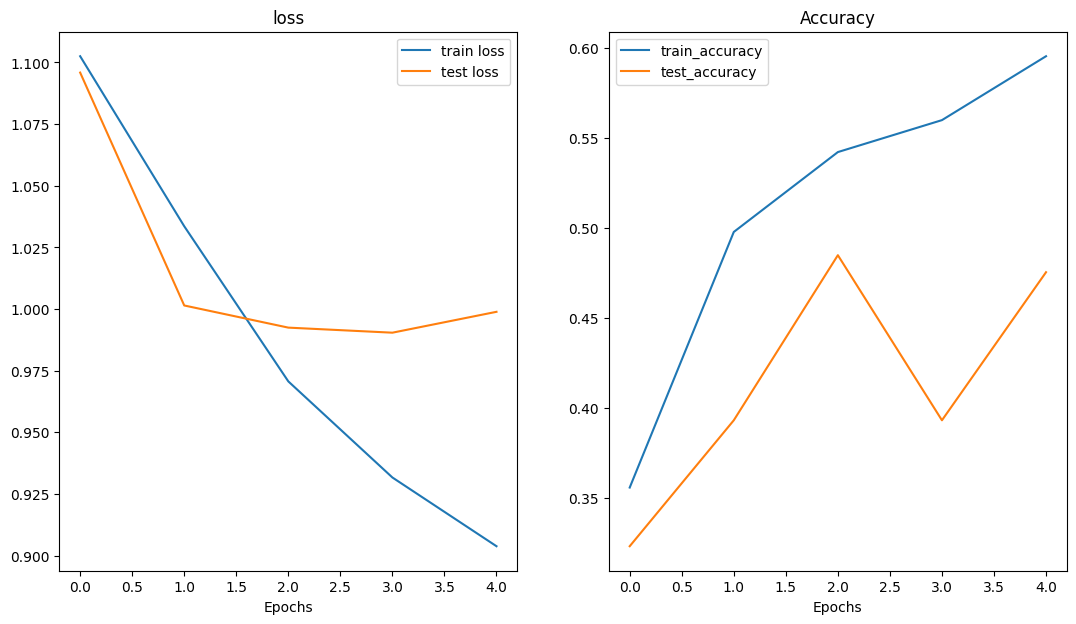

In [207]:
plot_loss_curves(model_0_results)

## 9. MODEL 1 : TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentation

In [208]:
# transform wtih trivial
train_transfrom_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

train_transfrom_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `dataset` and `DataLoader` with data augmentation

In [210]:
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transfrom_trivial)

test_data_augmented = datasets.ImageFolder(root=test_dir,
                                            transform=train_transfrom_trivial)

In [211]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)


test_dataloader_augmented = DataLoader(test_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

### 9.3 construct and train model_1

diff : augmenting the data

In [212]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [216]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

start_time = timer()

model_1_results = train(model=model_1,
                        train_datalaoder=train_dataloader_augmented,
                        test_dataloader=test_dataloader_augmented,
                        loss_fn=loss_fn,
                        optimizer=optimizer, epochs=NUM_EPOCHS,
                        )

end_time = timer()
print(f'total train time for model_1 : {end_time-start_time:.3f} sec')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 | Train loss : 1.1041 | Test loss : 1.0927 | Train acc : 0.3556, test_acc : 0.3116 
Epoch 1 | Train loss : 1.0281 | Test loss : 1.1562 | Train acc : 0.5244, test_acc : 0.3125 
Epoch 2 | Train loss : 0.9681 | Test loss : 0.9831 | Train acc : 0.5378, test_acc : 0.5047 
Epoch 3 | Train loss : 0.9511 | Test loss : 0.9879 | Train acc : 0.5644, test_acc : 0.4545 
Epoch 4 | Train loss : 0.8841 | Test loss : 0.9721 | Train acc : 0.6222, test_acc : 0.4943 
total train time for model_1 : 19.128 sec


In [217]:
model_1_results

{'train_loss': [1.1041076599227058,
  1.0281382184558445,
  0.9681389980514844,
  0.951137170791626,
  0.8840617319941521],
 'train_acc': [0.35555555555555557,
  0.5244444444444445,
  0.5377777777777778,
  0.5644444444444444,
  0.6222222222222222],
 'test_loss': [1.0927119652430217,
  1.1562487284342449,
  0.9831331570943197,
  0.9878676335016886,
  0.9721486767133077],
 'test_acc': [0.31155303030303033,
  0.3125,
  0.5047348484848485,
  0.4545454545454546,
  0.4943181818181818]}

### 9.4 plot loss curves of model_1

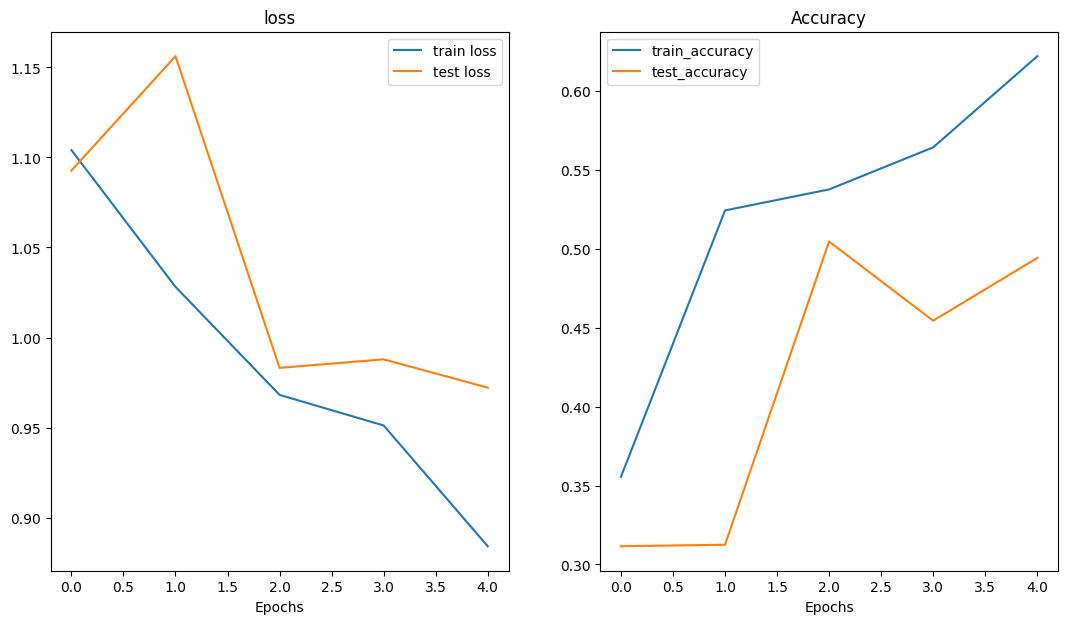

In [218]:
plot_loss_curves(model_1_results)

## 10. Compare model results

There are two diff ways :  
1. Hard coding (we are doing)
2. PyTorch + Tensorboard
3. Weight and biases
4. mlflow

In [220]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.102525,0.355556,1.095891,0.322917
1,1.033582,0.497778,1.001460,0.392992
2,0.970675,0.542222,0.992479,0.484848
3,0.931712,0.560000,0.990426,0.392992
4,0.903843,0.595556,0.998892,0.475379


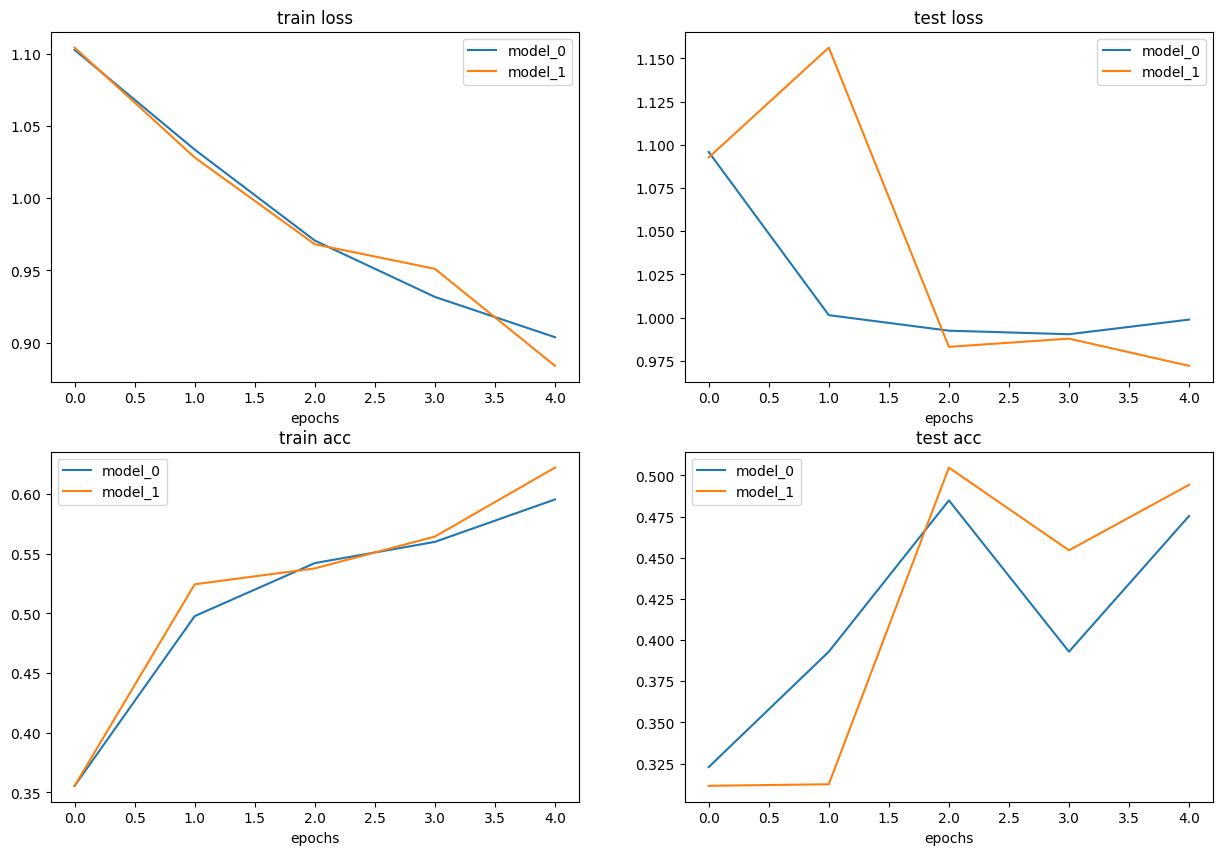

In [224]:
plt.figure(figsize=(15,10))

epochs = range(len(model_0_df))

# plt train lows
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label="model_0")
plt.plot(epochs, model_1_df['train_loss'], label="model_1")
plt.title('train loss')
plt.xlabel('epochs')
plt.legend();

# plt test lows
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df['test_loss'], label="model_0")
plt.plot(epochs, model_1_df['test_loss'], label="model_1")
plt.title('test loss')
plt.xlabel('epochs')
plt.legend();


# plt train acc
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df['train_acc'], label="model_0")
plt.plot(epochs, model_1_df['train_acc'], label="model_1")
plt.title('train acc')
plt.xlabel('epochs')
plt.legend();

# plt test lows
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df['test_acc'], label="model_0")
plt.plot(epochs, model_1_df['test_acc'], label="model_1")
plt.title('test acc')
plt.xlabel('epochs')
plt.legend();

## 11. Making a prediction on a custom image

testing on image that is neither in training or testing data

In [226]:
import requests
custom_image_path = data_path / "04_pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/04-pizza-dad.jpeg?raw=true')
    print('Downloading....')
    f.write(request.content)
else:
  print('already exist.')


Downloading....


### 11.1 Loading in a custom image with Pytorch

* in tensor form (torch.float32)
* of shape 64x64x3
* on right device


In [227]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

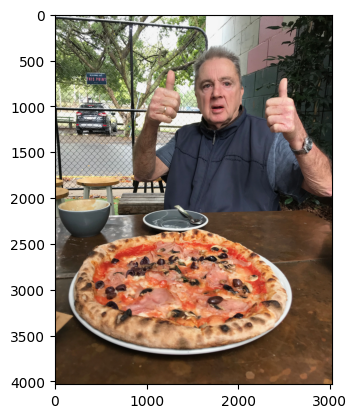

In [228]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [229]:
print(f'Custom image tensor : {custom_image_uint8}')
print(f'Custom image shape : {custom_image_uint8.shape}')
print(f'Custom image dtype : {custom_image_uint8.dtype}')


Custom image tensor : tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape : torch.Size([3, 4032, 3024])
Custom image dty

### 11.2 Making a prediction on custom image with pytorch model

In [232]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8)

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [235]:
# converting custom image into float32 tensor
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image.dtype

torch.float32

In [236]:
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [237]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image).to(device)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [240]:
# create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

# target imgage transform
custom_image_transformed = custom_image_transform(custom_image)
custom_image_transformed.shape

torch.Size([3, 64, 64])

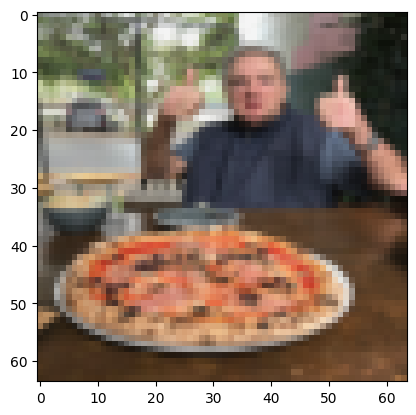

In [241]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [243]:
# this will error - no batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [244]:
custom_image_transformed.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [247]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0))
custom_image_pred

tensor([[ 0.3223, -0.4935, -0.0715]])

In [250]:
class_names[custom_image_pred.argmax()]

'pizza'

### 11.3 Putting custom image prediction together
Ideal outcome :  
a function where we pass an image path and our model predict -> plot image + prediction

In [257]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

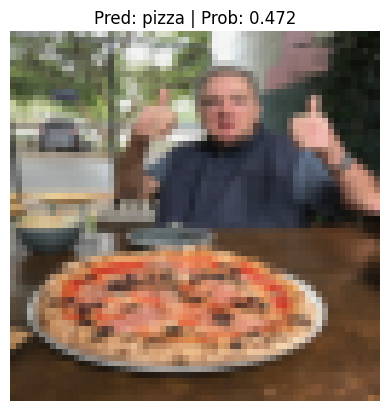

In [262]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)